In [98]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [126]:
# 环境搭建 step reset
class Env:
    '''
    state = [p_t, b_t, B_t, v_t,t]
    p_t: 可再生能源发电输出
    b_t: 不可转移的电力需求
    B_t: ESS存储容量
    v_t: 买入电力价格
    t :  小时数
    '''
    def __init__(self, ):
        #p、b、v分别表示可再生能源发电输出、不可转移的电力需求、买入能源价
        self.n_c = 0.95 #充电效率
        self.n_d = 0.95 #放电效率
        self.b = 1 #奖励惩罚系数
        self.c_t = 0.1 #充电能量  #算出
        self.d_t = -0.1 #放电能量 #算出
        self.Ess_old = 0.001 #ESS折旧率
        self.g_t = 0.1  #公网获取电力 #s算出
        self.v_t = 0.1  #买入电力价格 #得到
        self.u_t = 0.9*self.v_t  # 卖出电力价格 #算出
        self.c_max = 3 #最大充电能量
        self.d_max = 3 #最大放电能量
        self.B_max = 6 #最大ESS容量
        self.B_min = 0.1*self.B_max #最小ESS容量
        self.B_t = 0.1 #ESS存储容量 #得到
        self.t = 0 #小时数
        self.day = 1 #天数 #1-122 表示第1天到第122天
        self.data_p_t = np.genfromtxt('./Data/solar_double.csv', delimiter=',') # [1][0]  1-365 0-23
        self.data_b_t = np.genfromtxt('./Data/base_load_modified.csv', delimiter=',') # [1][0]  1-122 0-23
        self.data_v_t = np.genfromtxt('./Data/price_modified.csv', delimiter=',',encoding='utf-8') # [1][0]  1-122 0-23
 
    def C1(self):
        self.u_t = 0.9*self.v_t
        self.g_t = self.b_t - self.p_t + self.c_t + self.d_t   #self.c_t前面有负号时收敛 正号不收敛 ？？？
        return (self.v_t - self.u_t ) / 2 * np.abs(self.g_t) + (self.u_t + self.v_t) / 2 * (self.g_t) 
    def C2(self):
        return self.Ess_old*(np.abs(self.c_t) + np.abs(self.d_t))

    def step(self, action):  # 外部调用这个函数来改变当前位置 # 这个action =f_t #动作是无限的，因为是个函数 f的范围[-d,c]=[-3,3]
        
        p_t, b_t, B_t, v_t, t = self.state
        #done = False
        self.t = t + 1
        if self.t > 23:
            self.t = 0
            #done = True
        if action >=  0: 
            self.c_t = action
            self.d_t = 0
            if self.c_t >= min(self.c_max, (self.B_max-B_t)/self.n_c):
                self.c_t = min(self.c_max, (self.B_max-B_t)/self.n_c)
        else:
            self.c_t = 0
            self.d_t = action
            if self.d_t <= max(-self.d_max, (self.B_min-B_t)*self.n_d):
                self.d_t = max(-self.d_max, (self.B_min-B_t)*self.n_d)

        reward = -self.b *(self.C1() + self.C2())
        
        # 1种动作, 
        self.p_t = self.data_p_t[self.day][int(self.t)] #可再生能源发电输出 
        self.b_t = self.data_b_t[self.day][int(self.t)]     #不可转移的电力需求 应该要获取数据
        self.B_t = B_t + self.n_c *self.c_t +self.d_t/self.n_d   #ESS存储容量
        self.v_t = self.data_v_t[self.day][int(self.t)]     #买入电力价格 可能要获取数据
        #self.t = t + 1    #小时数
        next_state = np.array([self.p_t, self.b_t, self.B_t, self.v_t,self.t], dtype=np.float32)
        self.state = next_state
        

        return next_state, reward #, done
    
    def reset(self): 
        self.p_t = self.data_p_t[self.day][0] #可再生能源发电输出 -> 太阳能
        self.b_t = self.data_b_t[self.day][0] #不可转移的电力需求 -> 负载
        self.B_t = 0.2 * self.B_max
        self.v_t = self.data_v_t[self.day][0]
        self.t = 0                  
        self.state = np.array([self.p_t, self.b_t, self.B_t, self.v_t,self.t], dtype=np.float32)

        return self.state#np.array(self.state, dtype=np.float32)
    
    def random_day(self):
        self.day = int(np.random.uniform(1, 60)) #从1-60天中随机选取一天

    def normalize(self, state):
        state[0]=(state[0]-0)/(5.31) 
        state[1]=(state[1]-0)/(11.2233)
        state[2]=(state[2]-self.B_min)/(self.B_max-self.B_min)
        state[3]=(state[3]-0.0808)/(0.325-0.0808)
        state[4]=state[4]/23

        return state

     
    
    # def test_day(self):
    #     self.day = 61
        
    # def test_step(self,action):
    #     p_t, b_t, B_t, v_t, t = self.state
    #     #done = False
    #     self.t = t + 1
    #     if self.t > 23:
    #         self.t = 0
    #         self.day += 1
    #         #done = True
    #     if action >=  0: 
    #         self.c_t = action
    #         self.d_t = 0
    #         if self.c_t >= min(self.c_max, (self.B_max-B_t)/self.n_c):
    #             self.c_t = min(self.c_max, (self.B_max-B_t)/self.n_c)
    #     else:
    #         self.c_t = 0
    #         self.d_t = action
    #         if self.d_t <= min(-self.d_max, (self.B_min-B_t)*self.n_d):
    #             self.d_t = min(-self.d_max, (self.B_min-B_t)*self.n_d)
        
    #     # 1种动作, 
    #     self.p_t = self.data_p_t[self.day][int(self.t)] #可再生能源发电输出 
    #     self.b_t = self.data_b_t[self.day][int(self.t)]     #不可转移的电力需求 应该要获取数据
    #     self.B_t = B_t + self.n_c *self.c_t +self.d_t/self.n_d   #ESS存储容量
    #     self.v_t = self.data_v_t[self.day][int(self.t)]     #买入电力价格 可能要获取数据
    #     #self.t = t + 1    #小时数
    #     next_state = np.array([self.p_t, self.b_t, self.B_t, self.v_t,self.t], dtype=np.float32)
    #     self.state = next_state
    #     reward = -self.b *(self.C1() + self.C2())

    #     return next_state, reward #, done
en = Env()
state =en.reset() 
print(state)
#state = en.normalize(state) # 归一化
print(state)
print(en.state)
# action = agent.take_action(state)
next_state, reward = en.step(0.1)
print(next_state, reward)

next_state, reward = en.step(0.1)
print(next_state, reward)


[0.         2.5178332  1.2        0.11613875 0.        ]
[0.         2.5178332  1.2        0.11613875 0.        ]
[0.         2.5178332  1.2        0.11613875 0.        ]
[0.         2.9308     1.2950001  0.10985541 1.        ] -0.30413189100295374
0
[0.         2.3704834  1.3900001  0.10975792 2.        ] -0.3330497978436


In [100]:
# 策略网络 和 价值网络

# 先用单隐层测试一遍
# 策略网络 这里是单隐层
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim) # 均值
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim) # 方差
 
    def forward(self, x):
        x = F.relu(self.fc1(x)) # 激活函数
        mu = 3.0 * torch.tanh(self.fc_mu(x)) #从[-1,1]*3 确保均值范围为[-3,3]
        std = F.softplus(self.fc_std(x)) # 保证方差为正数 softplus = log(1+exp(x))
        return mu, std # 返回高斯分布的均值和方差
# 双隐层    
class PolicyNetDiscrete_hems(torch.nn.Module): #hidden_dim_1,hidden_dim_2 300,600
    def __init__(self, state_dim, hidden_dim_1,hidden_dim_2 ,action_dim):
        super(PolicyNetDiscrete_hems, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim_1)
        self.fc2 = torch.nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc_mu = torch.nn.Linear(hidden_dim_2, action_dim) # 均值
        self.fc_std = torch.nn.Linear(hidden_dim_2, action_dim) # 方差

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = 3.0 * torch.tanh(self.fc_mu(x)) #从[-1,1]*3 确保均值范围为[-3,3]
        std = F.softplus(self.fc_std(x)) # 保证方差为正数 softplus = log(1+exp(x))
        return mu, std # 返回高斯分布的均值和方差

# 价值网络
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
# 双隐层    #hidden_dim_1,hidden_dim_2 300,600
class ValueNet_hems(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim_1,hidden_dim_2):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim_1)
        self.fc2 = torch.nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = torch.nn.Linear(hidden_dim_2,1)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [101]:
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy() # 转换为numpy
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]: # 从后往前 最新的在最后
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse() # 从前往后顺序
    return torch.tensor(advantage_list, dtype=torch.float)

In [172]:
class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)
        self.gamma = gamma # 折扣因子
        self.lmbda = lmbda # GAE参数
        self.epochs = epochs # 迭代次数
        self.eps = eps # PPO算法的参数
        self.device = device 

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state) # 得到均值和方差
        action_dist = torch.distributions.Normal(mu, sigma)  # normal是正态分布
        action = action_dist.sample()
        return action.item() # 返回一个动作 这里[]是因为返回的是一个列表

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        #dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)
        rewards = rewards#(rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练 

        td_target = rewards + self.gamma * self.critic(next_states) #* (1 -dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)

        # 这三步和离散动作的PPO不一样
        mu, std = self.actor(states)  
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())### # 动作是正态分布 得出动作的概率
        old_log_probs = action_dists.log_prob(actions)  #.log_prob 

        for _ in range(self.epochs): #
            mu, std = self.actor(states) ##
            action_dists = torch.distributions.Normal(mu, std) ##
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))  
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
p = PPOContinuous(5, 64, 1, 0.0003, 0.0003, 0.95, 10, 0.2, 0.99, 'cpu')
state = en.reset()
print(p.take_action(state))
#state = en.normalize(state) # 归一化
print(state)
#print(en.state[4])
action = p.take_action(state)
print(action*3)
next_state, reward = en.step(action*3)
print(next_state, reward)
print(en.d_t,en.c_t)
#next_state = en.normalize(next_state)
#print(next_state)
action = p.take_action(next_state)
#print(action*3)
next_state, reward = en.step(action*3)
#print(next_state, reward)

1.1492865085601807
[0.         2.5178332  1.2        0.11613875 0.        ]
5.19601035118103
[0.         2.9308     4.05       0.10985541 1.        ] -0.6438342660029538
0 3


In [115]:
from tqdm import tqdm
# 训练的时候拿60天的数据，一次训练一天，测试的时候拿30天的数据，一次测试30天
# 这里是训练
def train_on_policy_agent_hems(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                env.random_day() ## 随机选取一天
                state = env.reset() 
                #print('state:',state)
                #done = False
                #while not done:
                for _ in range(24):
                    #state = env.normalize(state) # 归一化
                    action = agent.take_action(state)
                    #action = action*env.c_max  #反归一化
                    next_state, reward = env.step(action)  #
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    #transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

# def test_on_policy_agent_hems(env, agent):
#     return_list = []
#     for i in range(1):
#         with tqdm(total=int(1), desc='Iteration %d' % i) as pbar:
#             for i_episode in range(1):
#                 episode_return = 0
#                 transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
#                 env.random_day() ## 随机选取一天
#                 state = env.reset() 
#                 #while not done:
#                 for _ in range(24*30):  #1、改
#                     action = agent.take_action(state) 
#                     next_state, reward = env.test_step(action)   #2、改
#                     transition_dict['states'].append(state)
#                     transition_dict['actions'].append(action)
#                     transition_dict['next_states'].append(next_state)
#                     transition_dict['rewards'].append(reward)
#                     #transition_dict['dones'].append(done)
#                     state = next_state
#                     episode_return += reward
#                     #print('episode_return:',episode_return) #可视
#                 return_list.append(episode_return)
#                 #agent.update(transition_dict)
#                 #if (i_episode+1) % 10 == 0:
#                 pbar.set_postfix({'episode': '%d' % (1 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
#                 pbar.update(1)
#     return return_list

In [123]:
actor_lr = 1e-4# #论文1e-4 #越小越稳定
critic_lr = 1e-3# #论文1e-3
num_episodes = 2000  #论文里3000
hidden_dim = 128   #论文里 300*600
gamma = 0.995 #折扣因子
lmbda = 0.95 #GAE参数 #自设
epochs = 10 # 每轮训练的次数 #自设
eps = 0.2  #clip截断 #自设 eps越大，更新幅度越大
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 环境
env = Env()
state_dim = 5 # 状态维度
action_dim  = 1 # 动作维度
torch.manual_seed(0)
np.random.seed(0)

#state_dim = env.observation_space.shape[0] # 状态维度
#action_dim = env.action_space.n  # 动作维度

agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,epochs, eps, gamma, device)

return_list = train_on_policy_agent_hems(env, agent, num_episodes)

Iteration 9: 100%|██████████| 200/200 [00:12<00:00, 15.67it/s, episode=2000, return=2.186]


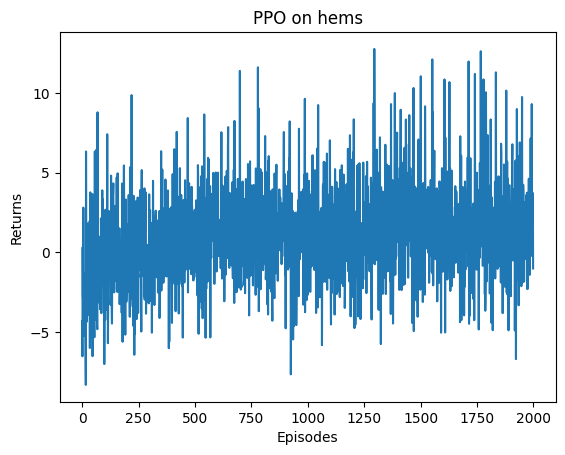

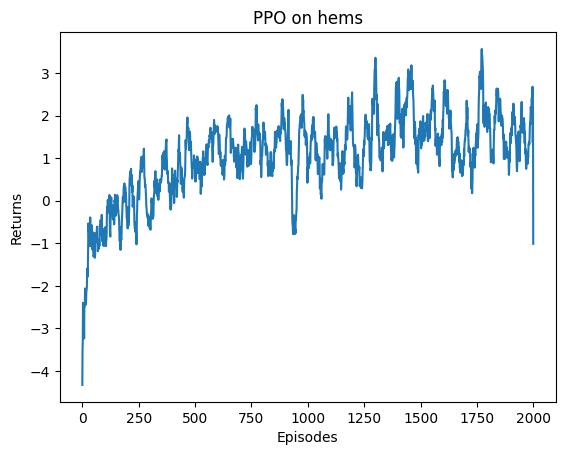

In [124]:
env_name = 'hems'
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

#  moving_average函数用于计算滑动平均值
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) #
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

mv_return = moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [42]:
# 保存模型
n =0
torch.save(agent.actor.state_dict(), './Model/actor_{}.pth'.format(n)) #保存到本地
torch.save(agent.critic.state_dict(), './Model/critic_{}.pth'.format(n)) #保存到本地
# 加载模型
agent.actor.load_state_dict(torch.load('./Model/actor_{}.pth'.format(n)))
agent.critic.load_state_dict(torch.load('./Model/critic_{}.pth'.format(n)))

# 测试
env = Env()
torch.manual_seed(0)
np.random.seed(0)

return_list = test_on_policy_agent_hems(env, agent)
print(return_list)


Iteration 0: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, episode=1, return=-171.575]

[-171.57514872065713]


In [20]:
### 测试###
import gym
env_name = 'CartPole-v0'
env = gym.make(env_name)
#env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print('state_dim:', state_dim)
print('action_dim:', action_dim)
print(type(state_dim))
state = env.reset()
print(state[0])
#打印动作的最大值

print(env.action_space)

state_dim: 4
action_dim: 2
<class 'int'>
[ 0.02622788  0.00636261  0.00409673 -0.00818955]
Discrete(2)


d:\softwares\anaconda3\envs\myrl\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [23]:
import gym
env_name = 'Pendulum-v1'
env = gym.make(env_name)
#打印动作的最大值
print(env.action_space)
print(env.action_space.high)
print(env.action_space.low)

Box(-2.0, 2.0, (1,), float32)
[2.]
[-2.]
